<a href="https://colab.research.google.com/github/LeeSeungwon89/Deep-learning_Theory/blob/main/8-2%20%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8-2 합성곱 신경망을 사용한 이미지 분류**

## **패션 MNIST 데이터 불러오기**

패션 MNIST 데이터를 준비하겠습니다. 다만 이전 챕터에서 수행했던 전처리 과정과 다른 부분이 있습니다. 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 `reshape()` 메서드나 `Flatten` 클래스를 사용하여 일렬로 펼쳤습니다. 그러나 합성곱 신경망에서는 2차원 이미지를 바로 사용하므로 일렬로 펼치는 작업을 수행할 필요가 없습니다. 다만 입력 이미지는 깊이 차원(채널)이 있어야 합니다. 흑백 이미지는 채널 차원이 없는 2차원 배열이지만 `Conv2D` 층을 사용하려면 마지막에 채널 차원을 추가해야 합니다. `reshape()` 메서드를 사용하면 전체 배열 차원을 그대로 유지하면서 차원만 추가할 수 있습니다.

데이터를 준비하겠습니다.

In [12]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# 기존 (48000, 28, 28) 3차원 배열을 (48000, 28, 28, 1) 4차원 배열로 차원을 바꿉니다.
# 데이터 스케일을 0 ~ 1 사이로 바꾸기 위해 255로 나눕니다.
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target,
                                                                      test_size=0.2, random_state=42)

## **합성곱 신경망 만들기**

`Sequential` 클래스의 인스턴스를 생성하여 처음 합성곱 층인 `Conv2D`를 추가하겠습니다.

In [13]:
model = keras.Sequential()
# 필터 32개, 커널 (3, 3), 렐루 함수, 세임 페딩을 지정합니다.
# 커널의 경우 (3, 3)처럼 가로세로 크기가 같으면 `3`을 지정해도 됩니다.
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(28, 28, 1)))

입력 차원을 `(28, 28)`이 아닌 `(28, 28, 1)`을 지정한 이유는 위 전처리 과정에서 기존 이미지를 4차원인 (48000, 28, 28, 1)로 변경했기 때문입니다.

풀링 층을 추가하겠습니다.

In [14]:
# 전형적인 풀링 크기인 (2, 2)를 지정합니다.
# `Conv2D` 클래스처럼 가로세로 크기가 같으므로 `2`를 지정해도 됩니다.
model.add(keras.layers.MaxPooling2D(2))

(28, 28) 이미지에 세임 패딩을 적용했으므로 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일합니다. 여기에 (2, 2) 풀링을 적용했으므로 특성 맵 크기는 절반으로 축소됩니다. 아울러 합성곱 층에서 필터 32개를 사용했으므로 특성 맵 깊이는 32입니다. 궁극적으로 특성 맵 크기는 (14, 14, 32)가 됩니다.

처음 합성곱-풀링 층 다음에 새로운 합성곱-풀링 층을 추가해 보겠습니다.

In [15]:
# 두 번째 층부터는 입력을 지정하지 않습니다. 
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

세임 패딩을 적용했으므로 입력의 가로세로 크기는 그대로입니다. 풀링 층에서 크기를 절반으로 줄이는 것입니다. 필터 64개를 사용했으므로 특성 맵 크기는 (7, 7, 64)가 됩니다.

특성 맵을 일렬로 펼치겠습니다. 유닛 10개를 가진 밀집 출력층에서 확률을 계산하기 때문입니다. 여기서는 특성 맵을 일렬로 펼치고 밀집 은닉층 하나를 추가해 보겠습니다. 

In [16]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
# 드롭아웃 층을 추가하여 은닉층의 과대적합을 방지합니다.
model.add(keras.layers.Dropout(0.4))
# 다중 분류이므로 소프트맥스 함수를 사용합니다.
model.add(keras.layers.Dense(10, activation='softmax'))

모델 구조를 확인해 보겠습니다.

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

합성곱 층과 풀링 층이 적절하게 배치됐습니다. 처음 합성곱 층에서 32였던 깊이가 두 번째 합성곱 층에서 64로 두 배 증가하고, 28이었던 가로세로 크기는 절반으로 줄고 다시 절반으로 줍니다. 최종 특성 맵 크기는 (7, 7, 64)입니다.

모델 파라미터 개수는 처음 합성곱 층의 경우 필터는 32개, 크기는 (3, 3), 깊이는 1, 절편은 32개(필터 개수와 같음)이므로 총 320개(3 x 3 x 1 x 32 + 32)입니다. 두 번째 합성곱 층의 경우 필터는 64개, 크기는 (3, 3), 깊이는 32, 절편은 64개이므로 18,496개(3 x 3 x 32 x 64 + 64)입니다.

은닉층의 경우 `Flatten` 클래스로 특성 맵 (7, 7, 64)를 1차원으로 펼치면 (3146,)이 되고, 이를 유닛 100개와 연결하면 파라미터 개수는 313,700개(3,136 x 100 + 100)입니다. 출력층의 경우 유닛 10개와 연결하면 1010개(100 x 10 + 10)입니다.

층의 구성을 다른 방식으로 확인해 보겠습니다. 케라스의 `utils` 모듈이 가진 `plot_model()` 메서드를 사용하여 층의 구성을 그림으로 표현해 보겠습니다. 이 메서드의 매개변수 목록은 아래와 같습니다.

- `to_file`: 파일 이름을 지정하면 그림을 파일로 저장합니다.

- `show_shapes`: 층의 입력, 출력 크기를 표시합니다. 디폴트는 `False`입니다.

- `show_layer_names`: 층 이름을 출력합니다. 디폴트는 `True`입니다.

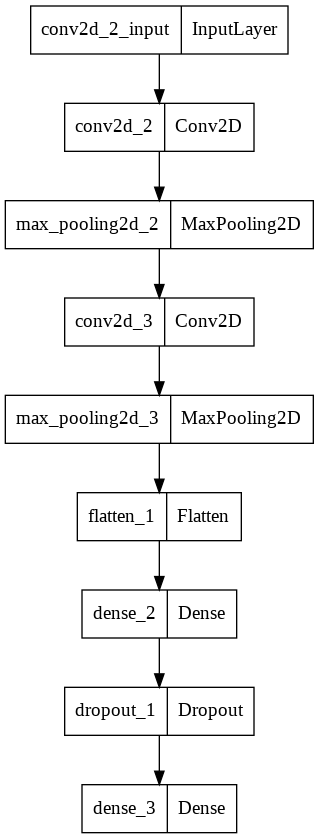

In [18]:
keras.utils.plot_model(model)

## **모델 컴파일과 훈련**

모델을 컴파일하고 훈련해 보겠습니다.


In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5181 - accuracy: 0.8141 - val_loss: 0.3457 - val_accuracy: 0.8706
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3429 - accuracy: 0.8761 - val_loss: 0.2765 - val_accuracy: 0.8992
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2920 - accuracy: 0.8955 - val_loss: 0.2610 - val_accuracy: 0.9026
Epoch 4/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2580 - accuracy: 0.9062 - val_loss: 0.2368 - val_accuracy: 0.9114
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2344 - accuracy: 0.9137 - val_loss: 0.2258 - val_accuracy: 0.9167
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2142 - accuracy: 0.9209 - val_loss: 0.2319 - val_accuracy: 0.9161
Epoch 7/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1951 - accuracy: 0.9263 - val_loss: 0.2252 - val_accuracy:

훈련 데이터 세트의 정확도가 많이 향상됐습니다.

손실 그래프를 그려보겠습니다.

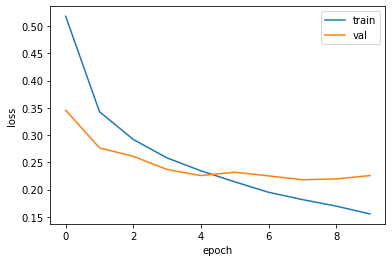

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 데이터 세트에 대한 손실이 감소하다가 정체되고 훈련 데이터 세트에 대한 손실은 계속 낮아집니다. 8번째 에포크가 최적입니다.

`EalryStopping` 클래스를 `restore_best_weights=True`로 지정했으므로 모델 객체는 최적 파라미터로 복원된 상태입니다. `ModelCheckPoint` 콜백이 저장한 `best_cnn_model.h5` 파일을 로드할 필요가 없습니다. 검증 데이터 세트에 대한 성능을 평가해 보겠습니다.

In [21]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.2180 - accuracy: 0.9201


[0.2180130034685135, 0.9200833439826965]

8번째 에포크의 출력과 같습니다.

훈련된 모델을 토대로 새 데이터에 대한 예측을 생성해 보겠습니다. 편의상 검증 데이터 세트의 첫 번째 샘플을 처음 본 이미지로 가정하겠습니다. 일단 첫 번째 샘플 이미지를 확인하겠습니다.

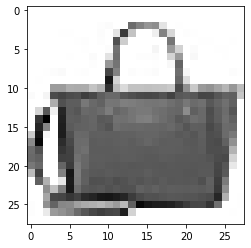

In [22]:
# 흑백 이미지는 깊이 차원이 존재하지 않습니다. (28, 28, 1) 크기를 (28, 28)로 차원을 줄입니다.
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

이 샘플에 대한 예측을 생성해 보겠습니다.

In [25]:
# `val_scaled[0:1]`처럼 슬라이싱을 사용한 이유는 아래에서 설명합니다.
preds = model.predict(val_scaled[0:1])
print(preds)

[[1.0155829e-19 1.7542408e-27 2.0884033e-24 3.1996176e-25 7.9922239e-21
  9.7617692e-21 4.1093567e-20 2.1080484e-21 1.0000000e+00 8.5877887e-22]]


클래스 10개에 대한 예측 확률을 출력했습니다. 9번째 값은 1이고 다른 값은 거의 0에 가깝습니다. 즉 9번째 클라스에 속한다는 의미를 나타냅니다. 

참고로 `val_scaled[0]`이 아닌 `val_scaled[0:1]`처럼 슬라이싱 형태로 지정한 이유는 케라스의 `fit()`, `predict()`, 'evaluate()` 메서드는 입력의 첫 번째 차원이 배치 차원일 것으로 기대하기 때문입니다. 인덱싱과 달리 슬라이싱은 선택된 원소가 하나일지라도 전체 차원을 유지합니다. 따라서 샘플 하나를 전달할 때 (28, 28, 1)이 아닌 (1, 28, 28, 1)을 전달할 수 있습니다.

생성된 예측을 그래프화해 보겠습니다.

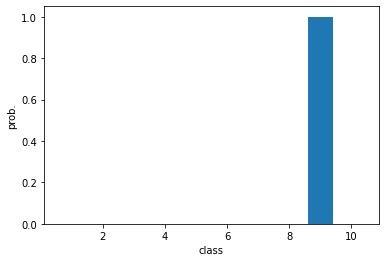

In [26]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

9번째 클래스만 높습니다.

패션 MNIST 데이터 세트의 레이블을 리스트로 저장하고 가장 높은 값을 레이블로 출력해 보겠습니다.

In [32]:
import numpy as np

classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈',
           '가방', '앵클 부츠']
print(classes[np.argmax(preds)])

가방


마지막으로 테스트 데이터 세트를 사용하여 합성곱 신경망의 일반화 성능을 판단해 보겠습니다. 실전에 투입했을 때의 성능을 예상하는 것입니다. 먼저 테스트 데이터 세트를 이전에 수행했던 것처럼 픽셀값 범위를 0 ~ 1 사이로 좁히고 이미지 크기를 (28, 28, 1)로 변경하겠습니다. 

In [30]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

테스트 데이터 세트에 대한 성능을 평가하겠습니다.

In [31]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2393 - accuracy: 0.9151


[0.2392507642507553, 0.9150999784469604]

테스트 데이터 세트의 성능 점수는 검증 데이터 세트의 성능 점수보다 낮은 것이 일반적입니다. 테스트 데이터 세트는 최종 모델의 일반화 성능을 평가할 목적을 가지며 모델을 출시하기 전에 한번만 사용해야 합니다. 여러 번 사용하면 실전에서 모델을 사용할 때 성능을 올바르게 예측할 수 없습니다.